# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [53]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from time import time  
from collections import defaultdict
from bs4 import BeautifulSoup 

#not sure we need that
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
raw_data = pd.read_csv("lyrics.csv")

In [4]:
raw_data.columns.values

array(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype=object)

In [10]:
raw_data.shape

(362237, 6)

In [11]:
print(raw_data.head(10))

   index                    song  year           artist genre  \
0      0               ego-remix  2009  beyonce-knowles   Pop   
1      1            then-tell-me  2009  beyonce-knowles   Pop   
2      2                 honesty  2009  beyonce-knowles   Pop   
3      3         you-are-my-rock  2009  beyonce-knowles   Pop   
4      4           black-culture  2009  beyonce-knowles   Pop   
5      5  all-i-could-do-was-cry  2009  beyonce-knowles   Pop   
6      6      once-in-a-lifetime  2009  beyonce-knowles   Pop   
7      7                 waiting  2009  beyonce-knowles   Pop   
8      8               slow-love  2009  beyonce-knowles   Pop   
9      9   why-don-t-you-love-me  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party 

In [12]:
raw_data['genre'].value_counts()

Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: genre, dtype: int64

In [6]:
print(raw_data.shape)
data = raw_data.loc[raw_data["lyrics"].str.len() > 3]
print(data.shape)

(362237, 6)
(266505, 6)


In [14]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelguedj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:

def document_to_words(text, remove_panctuations=True, remove_stopwords=False):
    if remove_panctuations:
      text = re.sub("[^a-zA-Z0-9]"," ", text)
    words = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]   
    return words

In [16]:
document_to_words(data["lyrics"][0], remove_stopwords=True)[:10]

['oh',
 'baby',
 'know',
 'gonna',
 'cut',
 'right',
 'chase',
 'women',
 'made',
 'like']

In [17]:
import nltk
nltk.download('punkt')

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelguedj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
tokenizer.tokenize(data["lyrics"][0].strip())

['Oh baby, how you doing?',
 "You know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you?",
 "You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy?",
 "Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what 

In [19]:
def document_to_sentences(document, tokenizer, remove_stopwords=False):
    sentences = []
    if tokenizer:
        raw_sentences = tokenizer.tokenize(document)
    else:
        raw_sentences = document
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(document_to_words(raw_sentence, remove_stopwords))
    return sentences

In [20]:
sentence = document_to_sentences(data["lyrics"][0], tokenizer, remove_stopwords=True)
len(sentence[1])

37

In [25]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for song_lyrics in data["lyrics"]:
    sentences += document_to_sentences(song_lyrics, tokenizer, remove_stopwords=True)

Parsing sentences from training set


In [23]:
def word2vec_hat(sentences, num_features=300, min_word_count=40, workers=4, 
             context=10, downsampling=1e-3, save_model=True):

    model = Word2Vec(sentences, workers=workers, size=num_features, 
                   min_count=min_word_count, window=context, sample=downsampling)

    if save_model:
        # If you don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
#         model.init_sims(replace=True)
        model.wv.init_sims
        # It can be helpful to create a meaningful model name and 
        # save the model for later use. You can load it later using Word2Vec.load()
        model_name = "{}features_{}minwords_{}context.wv.model".format(num_features, 
                                                              min_word_count, 
                                                              context)
        model.save(model_name)
 
    return model

In [26]:
word2vec_hat(sentences)

INFO - 16:38:52: collecting all words and their counts
INFO - 16:38:52: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:38:52: PROGRESS: at sentence #10000, processed 547073 words, keeping 24856 word types
INFO - 16:38:52: PROGRESS: at sentence #20000, processed 1002175 words, keeping 36701 word types
INFO - 16:38:52: PROGRESS: at sentence #30000, processed 1577546 words, keeping 45437 word types
INFO - 16:38:53: PROGRESS: at sentence #40000, processed 2132629 words, keeping 55005 word types
INFO - 16:38:53: PROGRESS: at sentence #50000, processed 2565209 words, keeping 60035 word types
INFO - 16:38:53: PROGRESS: at sentence #60000, processed 3125605 words, keeping 70378 word types
INFO - 16:38:53: PROGRESS: at sentence #70000, processed 3650087 words, keeping 80685 word types
INFO - 16:38:53: PROGRESS: at sentence #80000, processed 4152681 words, keeping 88085 word types
INFO - 16:38:53: PROGRESS: at sentence #90000, processed 4712834 words, keeping 92527 w

INFO - 16:39:03: PROGRESS: at sentence #820000, processed 43471094 words, keeping 323912 word types
INFO - 16:39:03: PROGRESS: at sentence #830000, processed 44172564 words, keeping 325593 word types
INFO - 16:39:03: PROGRESS: at sentence #840000, processed 44667279 words, keeping 330357 word types
INFO - 16:39:03: PROGRESS: at sentence #850000, processed 45114992 words, keeping 331606 word types
INFO - 16:39:03: PROGRESS: at sentence #860000, processed 45840735 words, keeping 334894 word types
INFO - 16:39:04: PROGRESS: at sentence #870000, processed 46364336 words, keeping 338759 word types
INFO - 16:39:04: PROGRESS: at sentence #880000, processed 46858701 words, keeping 340849 word types
INFO - 16:39:04: PROGRESS: at sentence #890000, processed 47371857 words, keeping 345358 word types
INFO - 16:39:04: PROGRESS: at sentence #900000, processed 47954498 words, keeping 346951 word types
INFO - 16:39:04: PROGRESS: at sentence #910000, processed 48459183 words, keeping 351406 word types


INFO - 16:39:48: EPOCH 1 - PROGRESS: at 77.49% examples, 925531 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:49: EPOCH 1 - PROGRESS: at 79.94% examples, 927210 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:50: EPOCH 1 - PROGRESS: at 81.69% examples, 924593 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:51: EPOCH 1 - PROGRESS: at 83.07% examples, 917176 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:52: EPOCH 1 - PROGRESS: at 84.95% examples, 915031 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:53: EPOCH 1 - PROGRESS: at 86.65% examples, 915373 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:54: EPOCH 1 - PROGRESS: at 88.61% examples, 917594 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:55: EPOCH 1 - PROGRESS: at 90.94% examples, 919615 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:56: EPOCH 1 - PROGRESS: at 93.70% examples, 921703 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:57: EPOCH 1 - PROGRESS: at 95.73% examples, 923483 words/s, in_qsize 7, out_qsize 0
INFO - 16:39:58: EPOCH 1 - PRO

INFO - 16:41:05: EPOCH 3 - PROGRESS: at 28.29% examples, 776426 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:06: EPOCH 3 - PROGRESS: at 30.05% examples, 782419 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:07: EPOCH 3 - PROGRESS: at 32.33% examples, 796158 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:08: EPOCH 3 - PROGRESS: at 34.62% examples, 806195 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:10: EPOCH 3 - PROGRESS: at 36.84% examples, 816285 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:11: EPOCH 3 - PROGRESS: at 38.78% examples, 824981 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:12: EPOCH 3 - PROGRESS: at 40.94% examples, 833273 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:13: EPOCH 3 - PROGRESS: at 43.28% examples, 842489 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:14: EPOCH 3 - PROGRESS: at 45.70% examples, 849640 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:15: EPOCH 3 - PROGRESS: at 47.98% examples, 853972 words/s, in_qsize 7, out_qsize 0
INFO - 16:41:16: EPOCH 3 - PRO

INFO - 16:42:27: worker thread finished; awaiting finish of 3 more threads
INFO - 16:42:27: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:27: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:27: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:27: EPOCH - 4 : training on 63696185 raw words (45785587 effective words) took 46.2s, 991369 effective words/s
INFO - 16:42:28: EPOCH 5 - PROGRESS: at 1.99% examples, 873972 words/s, in_qsize 7, out_qsize 0
INFO - 16:42:29: EPOCH 5 - PROGRESS: at 3.97% examples, 878252 words/s, in_qsize 7, out_qsize 0
INFO - 16:42:30: EPOCH 5 - PROGRESS: at 6.29% examples, 926430 words/s, in_qsize 7, out_qsize 0
INFO - 16:42:31: EPOCH 5 - PROGRESS: at 8.31% examples, 949677 words/s, in_qsize 7, out_qsize 0
INFO - 16:42:32: EPOCH 5 - PROGRESS: at 10.82% examples, 961521 words/s, in_qsize 7, out_qsize 0
INFO - 16:42:33: EPOCH 5 - PROGRESS: at 13.05% examples, 970227 words/s, in_qsize 7, out_qsize 

In [14]:
w2v_model = Word2Vec.load("300features_40minwords_10context.wv.model")

INFO - 16:23:13: loading Word2Vec object from 300features_40minwords_10context.wv.model
INFO - 16:23:13: loading wv recursively from 300features_40minwords_10context.wv.model.wv.* with mmap=None
INFO - 16:23:13: setting ignored attribute vectors_norm to None
INFO - 16:23:13: loading vocabulary recursively from 300features_40minwords_10context.wv.model.vocabulary.* with mmap=None
INFO - 16:23:13: loading trainables recursively from 300features_40minwords_10context.wv.model.trainables.* with mmap=None
INFO - 16:23:13: setting ignored attribute cum_table to None
INFO - 16:23:13: loaded 300features_40minwords_10context.wv.model


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [28]:
w2v_model.wv.most_similar("dog") 

INFO - 16:52:02: precomputing L2-norms of word weight vectors


[('hound', 0.6047170758247375),
 ('puppy', 0.5669090747833252),
 ('cat', 0.5553213357925415),
 ('dogs', 0.5495033860206604),
 ('barking', 0.5416650772094727),
 ('hog', 0.5347200036048889),
 ('frog', 0.5303950905799866),
 ('barkin', 0.5250210165977478),
 ('bark', 0.5211504697799683),
 ('doggy', 0.48853635787963867)]

In [29]:
w2v_model.wv.most_similar("love") 

[('baby', 0.554186224937439),
 ('loving', 0.5354353189468384),
 ('heart', 0.5152585506439209),
 ('oh', 0.5066409111022949),
 ('you', 0.4939931631088257),
 ('true', 0.48410582542419434),
 ('darling', 0.4810052216053009),
 ('lovin', 0.4613601565361023),
 ('me', 0.4605832099914551),
 ('darlin', 0.4548726975917816)]

In [30]:
w2v_model.wv.most_similar("war")

[('battle', 0.6541935801506042),
 ('waging', 0.6304421424865723),
 ('wars', 0.6265519261360168),
 ('waged', 0.5722817778587341),
 ('civil', 0.5561788082122803),
 ('battles', 0.496185839176178),
 ('tug', 0.48518654704093933),
 ('battlefield', 0.4778044819831848),
 ('fighting', 0.477022647857666),
 ('wage', 0.4723787009716034)]

In [31]:
w2v_model.wv.most_similar("blue") 

[('bluest', 0.5335527658462524),
 ('gray', 0.5190421938896179),
 ('grey', 0.47112494707107544),
 ('starry', 0.43493953347206116),
 ('cloudy', 0.4216483235359192),
 ('starlit', 0.4208819270133972),
 ('hue', 0.4200236201286316),
 ('tangerine', 0.4178546667098999),
 ('colour', 0.4062366485595703),
 ('misty', 0.40504148602485657)]

In [42]:
w2v_model.wv.most_similar("paris") 

[('france', 0.6699743866920471),
 ('spain', 0.5838769674301147),
 ('hilton', 0.5828134417533875),
 ('tokyo', 0.5712754726409912),
 ('italy', 0.5608839988708496),
 ('venice', 0.5596826672554016),
 ('london', 0.5530416369438171),
 ('miami', 0.5352116823196411),
 ('brazil', 0.5246003866195679),
 ('rome', 0.5206924676895142)]

In [43]:
w2v_model.wv.most_similar("jew") 

[('jewish', 0.5946222543716431),
 ('buddhist', 0.5576699376106262),
 ('muslim', 0.5428418517112732),
 ('caucasian', 0.5240269303321838),
 ('bishop', 0.5107120275497437),
 ('goat', 0.5064100027084351),
 ('christian', 0.4977492392063141),
 ('haitian', 0.49670469760894775),
 ('reggie', 0.4932796061038971),
 ('italian', 0.486927330493927)]

In [50]:
w2v_model.wv.most_similar("bitch") 

[('nigga', 0.7172577381134033),
 ('hoe', 0.7166839838027954),
 ('chick', 0.6396318078041077),
 ('shit', 0.6350769996643066),
 ('pussy', 0.6111509799957275),
 ('dick', 0.605313241481781),
 ('motherfucker', 0.6026188135147095),
 ('slut', 0.5907386541366577),
 ('ass', 0.5894578099250793),
 ('rari', 0.5888777375221252)]

In [92]:
w2v_model.wv.most_similar("success") 

[('failure', 0.5274873971939087),
 ('excess', 0.5129327774047852),
 ('progress', 0.5103586912155151),
 ('wealth', 0.49891579151153564),
 ('interest', 0.49818187952041626),
 ('importance', 0.4899829030036926),
 ('value', 0.4854126274585724),
 ('invest', 0.4848068058490753),
 ('financial', 0.4800871014595032),
 ('intelligence', 0.45601966977119446)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [95]:
w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.5984432697296143),
 ('kings', 0.4317205548286438),
 ('empress', 0.3948866128921509),
 ('princess', 0.39446741342544556),
 ('homecoming', 0.3881065249443054),
 ('throne', 0.3874613642692566),
 ('crowning', 0.3848448097705841),
 ('crowned', 0.38424116373062134),
 ('crown', 0.3822874128818512),
 ('majesty', 0.3679766058921814)]

In [93]:
w2v_model.wv.most_similar(positive=['man', 'king'], negative=['woman'])

[('ruler', 0.5510568618774414),
 ('leader', 0.4807005524635315),
 ('undisputed', 0.45438432693481445),
 ('kings', 0.4521034061908722),
 ('rodney', 0.43810364603996277),
 ('luther', 0.42439985275268555),
 ('messiah', 0.41927266120910645),
 ('crowned', 0.41513946652412415),
 ('chief', 0.4118346571922302),
 ('prince', 0.41021791100502014)]

In [87]:
w2v_model.wv.most_similar_cosmul(positive=['success', 'luck'], negative=['knowledge'])

[('beginner', 0.7942504286766052),
 ('fortune', 0.7577399611473083),
 ('lucky', 0.7482839822769165),
 ('best', 0.7395355105400085),
 ('gamble', 0.7368978261947632),
 ('friend', 0.7355175018310547),
 ('loser', 0.7343119382858276),
 ('bucks', 0.7279139161109924),
 ('starstruck', 0.7241196632385254),
 ('lorraine', 0.7211849689483643)]

In [84]:
w2v_model.wv.most_similar_cosmul(positive=['woman', 'uncle'], negative=['man'])

[('aunt', 0.7884104251861572),
 ('kate', 0.7596791386604309),
 ('jennifer', 0.7465906143188477),
 ('ann', 0.7454026341438293),
 ('auntie', 0.7445542812347412),
 ('anne', 0.739669680595398),
 ('melissa', 0.7384995222091675),
 ('louise', 0.7328769564628601),
 ('husband', 0.7328441739082336),
 ('barbara', 0.7294706106185913)]

In [83]:
w2v_model.wv.most_similar(positive=['future','success', 'man'], negative=['woman'])

[('progress', 0.5224085450172424),
 ('present', 0.47786039113998413),
 ('failure', 0.47170794010162354),
 ('economy', 0.46997013688087463),
 ('theory', 0.4682660698890686),
 ('survival', 0.4585574269294739),
 ('concept', 0.4516288638114929),
 ('policy', 0.44613367319107056),
 ('wealth', 0.443167507648468),
 ('legacy', 0.4400182366371155)]

In [46]:
vector = w2v_model.wv['king'] - w2v_model.wv['man'] + w2v_model.wv['woman']
w2v_model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('king', 0.7405559420585632),
 ('queen', 0.6157742738723755),
 ('woman', 0.43306297063827515),
 ('kings', 0.43230652809143066),
 ('princess', 0.4136694669723511),
 ('throne', 0.40156853199005127),
 ('empress', 0.3987256586551666),
 ('homecoming', 0.394988477230072),
 ('crowning', 0.39387229084968567),
 ('crown', 0.39278435707092285)]

In [47]:
# Cosine similarity
cosine_distance = w2v_model.wv.similarity("woman", "girl")
print("Cosine distance = ", cosine_distance)

import numpy as np
euclidean_distance = np.linalg.norm(w2v_model.wv["women"] - w2v_model.wv["girl"])
print("Euclidean distance = ", euclidean_distance)

Cosine distance =  0.55022025
Euclidean distance =  30.819527


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [53]:
dict_words = {}

with open("./SCL-OPP/SCL-OPP.txt","r") as f:
    lines = f.readlines()
    for line in lines:
        word = line.split("\t")
        dict_words[word[0]] = float(word[1])

In [55]:
model_vocab =  list(w2v_model.wv.vocab.keys())
#All the words shared between the sentiment lexicon and our lyrics corpus.
lexicon_words = []
for key,value in dict_words.items():
    if key in model_vocab:
        lexicon_words.append([key,value])
lexicon_df = pd.DataFrame(lexicon_words, columns=["Word","Sentiment"])

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(w2v_model[lexicon_df.Word], lexicon_df.Sentiment, test_size = 0.2, random_state=42)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Train Score: {}, Test Score {}".format(mse(lr.predict(X_train),y_train),mse(lr.predict(X_test),y_test)))

Train Score: 0.04021308565792459, Test Score 0.4019913434527408


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [69]:
not_in_lexicon = []
for word in model_vocab:
    if word not in lexicon_df['Word'].values:
        not_in_lexicon.append(word)

values = lr.predict(w2v_model[not_in_lexicon])

sents_df = pd.DataFrame((not_in_lexicon, values)).T
sents_df.columns = ["Word","Sentiment"]
sents_df.Sentiment = sents_df.Sentiment / max(np.abs(sents_df.Sentiment))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [70]:
sents_df.sort_values(by="Sentiment")

,Word,Sentiment
1468,tus,-1
14494,aku,-0.895411
14493,kau,-0.806599
726,las,-0.78831
17061,ang,-0.735961
...,...,...
7815,sunny,0.658691
1962,under,0.721021
100,if,0.723875
3060,harmony,0.730821


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [50]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from nltk.corpus import stopwords
def lyrics_to_wordlist( lyrics, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    lyrics_text = BeautifulSoup(lyrics).get_text()
    #  
    # 2. Remove non-letters
    lyrics_text = re.sub("[^a-zA-Z]"," ", lyrics_text)
    #
    # 3. Convert words to lower case and split them
    words = lyrics_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [54]:
genres = {genre:[] for genre in data.genre.unique()}
# 'Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal',
#       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'
by_genres = data.groupby(['genre'])["lyrics"].apply(list)
genres_text = {}
for genre in data.genre.unique():
    print(genre)
    genres[genre] = (lyrics_to_wordlist(' '.join(map(str, by_genres[genre])), remove_stopwords=True))
    genres_text[genre]= ' '.join(map(str, by_genres[genre]))


Pop
Hip-Hop
Not Available
Rock
Metal
Other
Country
Jazz
Electronic
Folk
R&B
Indie


In [55]:
from nltk.corpus import stopwords
def clean_text(text):
    text = BeautifulSoup(text).get_text()
    #  
    # 2. Remove non-letters
    text = re.sub("[^a-zA-Z]"," ", text)
    #
    # 3. Convert words to lower case and split them
    words = text.lower().split()
    #
    # 4. remove stop words 
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    #
    # 5. Return words as one document
    return(' '.join(words))

In [56]:
for genre in genres_text:
    print(genre)
    genres_text[genre] = clean_text( genres_text[genre])

Pop
Hip-Hop
Not Available
Rock
Metal
Other
Country
Jazz
Electronic
Folk
R&B
Indie


In [57]:
from collections import Counter
# Add to the dictionary if it doesn't exist. If it does, increase the count.
words_counter = Counter()
genres_words_counter = {}
word_per_ganer = {}
for genre in genres:
    word_per_ganer[genre] = len(genres[genre])
    words_counter += Counter(genres[genre])
    genres_words_counter[genre] = Counter(genres[genre])


In [58]:
top_3000 = [ word[0] for word in words_counter.most_common(3000)]
corpus = []
for genre in genres_text:
    print(genre)
    corpus.append(genres_text[genre])


Pop
Hip-Hop
Not Available
Rock
Metal
Other
Country
Jazz
Electronic
Folk
R&B
Indie


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn.pipeline import Pipeline


In [60]:
#Calculat tf-idf 
pipe = Pipeline([('count', CountVectorizer(vocabulary=top_3000)), ('tfid', TfidfTransformer())]).fit(corpus)


In [61]:
# count matrix
count_vector=pipe['count'].transform(corpus)
 
# tf-idf scores
tf_idf_vector= pipe['tfid'].transform(count_vector)

In [62]:
#Build on dictionary with all genres and top 3000 words
feature_names = pipe['count'].get_feature_names()
genre_tf_idf={}
genre_index = 0
for genre in genres:
    genre_tf_idf[genre]= dict(zip(feature_names, np.array( tf_idf_vector[genre_index].todense())[0]))
    genre_index +=1 



In [63]:
total_number_of_words = sum(words_counter.values())
top_3000_ratio_between_proportion_word_genre = {}
top_3000_relative_to_all_words = {}
number_of_genres = len(genres)

#compute for each word its relative abundance in each of the genres
for gener in genres:
    top_3000_ratio_between_proportion_word_genre[gener] = {}
    for word_in_top_3000 in top_3000:
        #compute for each word its relative abundance in each of the genres
        top_3000_ratio_between_proportion_word_genre[gener][word_in_top_3000] =  genres_words_counter[genre][word_in_top_3000] / word_per_ganer[genre]
 


#Compute the ratio between the proportion of each word in each genre 
#and the proportion of the word in the entire corpus (the background distribution)
for word_in_top_3000 in top_3000:
    top_3000_relative_to_all_words[word_in_top_3000] =  words_counter[word_in_top_3000] / total_number_of_words





In [70]:
#Pick the top 50 words for each genre. These words give good indication for that genre.
model= w2v_model
top_50_per_genre = {}
for genre in genres:
    top_50_per_genre[genre]=sorted(genre_tf_idf[genre].items() , reverse=True, key=lambda x: x[1])[:50]

top_significant_words = []
#Join the words from all genres into a single list of top significant words. 
for genre in genres:
    top_significant_words +=  [ word[0] for word in top_50_per_genre[genre]]
    
top_significant_words = list(set(top_significant_words))
word_vertor = []
for words in top_significant_words:
    word_vertor.append(model.wv[words])

    
# Create a colors array for each word (by genre)



genre_colors ={
"Pop":(0.6, 0.8, 0.8),
"Hip-Hop":(0.1, 0.4, 0.7),
"Not Available":(0.6, 0.8, 0.5),
"Other":(0.2, 0.6, 0.1), 
"Rock": (0.9, 0.6, 0.6),
"Metal":(0.8, 0.1, 0.1),
"Country":(0.9, 0.7, 0.4),
"Jazz":(1.0, 0.4, 0.0),
"Electronic": (0.7, 0.6, 0.8),
"Folk": (0.4, 0.2, 0.6),
"R&B":(1.0, 1.0, 0.6),
"Indie": (0.6, 0.3, 0.1)
}

word_colors = []
end_gener = []
for words in top_significant_words:
    max_tf_idf = 0
    max_genre = ""
    color = ""
    for genre in genres:
        if words in genre_tf_idf[genre].keys() and genre_tf_idf[genre][words] > max_tf_idf:
            max_tf_idf = genre_tf_idf[genre][words]
            max_genre = genre
            color = genre_colors[genre]
    word_colors.append(color)
    end_gener.append(max_genre)



In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


NameError: name 'word' is not defined

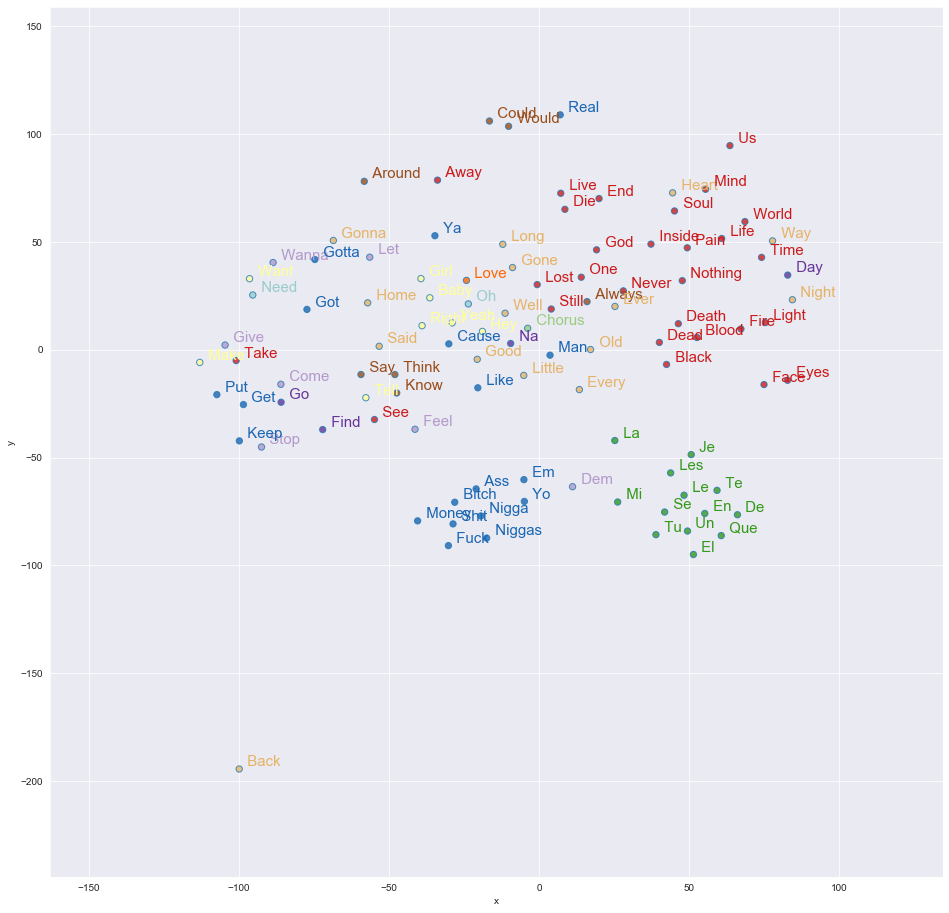

In [72]:
""" Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
its list of most similar words, and a list of words.
"""
#Compute tSNE transformation to 2D for all words, based on their word vectors
#Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

# Reduces the dimensionality from 3000 to 50 dimensions with PCA
reduc = PCA(n_components=21).fit_transform(word_vertor)

# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

# Sets everything up to plot
df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                   'y': [y for y in Y[:, 1]],
                   'words': top_significant_words,
                   'color': word_colors,
                   'gener':end_gener})


fig, _ = plt.subplots()
fig.set_size_inches(16, 16)

# Basic plot
p1 = sns.regplot(data=df,
                 x="x",
                 y="y",
                 fit_reg=False,
                 marker="o",
                 scatter_kws={'s': 40,
                              'facecolors': df['color']
                             }
                 
                ,label=df['gener']
                )

# Adds annotations one by one with a loop
for line in range(0, df.shape[0]):
     p1.text(df["x"][line],
             df['y'][line],
             '  ' + df["words"][line].title(),
             horizontalalignment='left',
             verticalalignment='bottom', size='medium',
             color=df['color'][line],
             weight='normal'
            ).set_size(15)


plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

plt.title('t-SNE visualization for {}'.format(word.title()))

plt.legend(["Pop","Hip-Hop","Not Available","Other", "Rock" ,"Metal" ,"Country","Jazz" ,"Electronic" ,"Folk" ,"R&B","Indie"])




In [113]:
print(w2v_model.wv.vocab[words2list[0]].count)

237243


In [109]:
import operator
sorted_d = sorted(w2v_model.wv.vocab.items(), key=operator.itemgetter(1))

In [125]:
from collections import OrderedDict
dd = OrderedDict(sorted(w2v_model.wv.vocab.items(), key=lambda x: x[1], reverse=True))

In [128]:
print(dd.keys())

odict_keys(['i', 'the', 'you', 'to', 'and', 'a', 'it', 'me', 's', 'my', 't', 'in', 'of', 'that', 'your', 'on', 'm', 'we', 'all', 'is', 'for', 'be', 'can', 'so', 'no', 'don', 'love', 'with', 'but', 'like', 'know', 'this', 'what', 'just', 'up', 're', 'when', 'll', 'oh', 'do', 'now', 'got', 'get', 'they', 'if', 'out', 'she', 'there', 'one', 'down', 'go', 'was', 'time', 'see', 'are', 'never', 've', 'let', 'will', 'he', 'from', 'not', 'want', 'have', 'baby', 'come', 'yeah', 'way', 'cause', 'at', 'say', 'as', 'back', 'make', 'take', 'her', 'how', 'life', 'here', 'la', 'feel', 'away', 'right', 'gonna', 'by', 'd', 'been', 'where', 'need', 'heart', 'man', 'could', 'more', 'ain', 'who', 'day', 'tell', 'night', 'que', 'our', 'world', 'through', 'why', 'or', 'wanna', 'girl', 'give', 'about', 'too', 'de', 'some', 'only', 'then', 'think', 'keep', 'again', 'still', 'good', 'his', 'us', 'eyes', 'won', 'little', 'chorus', 'said', 'over', 'them', 'every', 'around', 'well', 'had', 'ya', 'y', 'an', 'would

In [102]:
import numpy as np
words2 = w2v_model.wv.vocab.keys()
print(words2)
arr = np.empty(shape=(len(words2)))
words2list=list(words2)

dict_keys(['oh', 'baby', 'how', 'you', 'doing', 'know', 'i', 'm', 'gonna', 'cut', 'right', 'to', 'the', 'chase', 'some', 'women', 'were', 'made', 'but', 'me', 'myself', 'like', 'think', 'that', 'was', 'created', 'for', 'a', 'special', 'purpose', 'what', 's', 'more', 'than', 'feel', 'it', 'on', 'let', 'get', 'lost', 'don', 't', 'need', 'call', 'into', 'work', 'cause', 're', 'boss', 'real', 'want', 'show', 'consider', 'lucky', 'big', 'deal', 'why', 'well', 'got', 'key', 'my', 'heart', 'ain', 'd', 'rather', 'open', 'up', 'body', 'and', 'secrets', 'didn', 'inside', 'no', 'lie', 'too', 'wide', 'strong', 'won', 'fit', 'much', 'tough', 'he', 'talk', 'this', 'can', 'back', 'ego', 'such', 'huge', 'love', 'his', 'walk', 'usually', 'humble', 'now', 'choose', 'leave', 'with', 'or', 'could', 'have', 'blues', 'arrogant', 'confident', 'decide', 'when', 'find', 'working', 'damn', 'killing', 'them', 'legs', 'better', 'yet', 'thighs', 'matter', 'fact', 'smile', 'maybe', 'eyes', 'boy', 'site', 'see', 'ki

In [129]:
print(words2)

dict_keys(['oh', 'baby', 'how', 'you', 'doing', 'know', 'i', 'm', 'gonna', 'cut', 'right', 'to', 'the', 'chase', 'some', 'women', 'were', 'made', 'but', 'me', 'myself', 'like', 'think', 'that', 'was', 'created', 'for', 'a', 'special', 'purpose', 'what', 's', 'more', 'than', 'feel', 'it', 'on', 'let', 'get', 'lost', 'don', 't', 'need', 'call', 'into', 'work', 'cause', 're', 'boss', 'real', 'want', 'show', 'consider', 'lucky', 'big', 'deal', 'why', 'well', 'got', 'key', 'my', 'heart', 'ain', 'd', 'rather', 'open', 'up', 'body', 'and', 'secrets', 'didn', 'inside', 'no', 'lie', 'too', 'wide', 'strong', 'won', 'fit', 'much', 'tough', 'he', 'talk', 'this', 'can', 'back', 'ego', 'such', 'huge', 'love', 'his', 'walk', 'usually', 'humble', 'now', 'choose', 'leave', 'with', 'or', 'could', 'have', 'blues', 'arrogant', 'confident', 'decide', 'when', 'find', 'working', 'damn', 'killing', 'them', 'legs', 'better', 'yet', 'thighs', 'matter', 'fact', 'smile', 'maybe', 'eyes', 'boy', 'site', 'see', 'ki

**Keep only the 3,000 most frequent words (after removing stopwords):**

In [93]:
arr_3000_words=[]
array_3000_words=[]
word_count=w2v_model.wv.vocab[words2list[0]].count
arr_3000_words.append([words2list[0],word_count])
for i in range (len(words2)):
    word_count=w2v_model.wv.vocab[words2list[i]].count
    if (len(arr_3000_words)<3000):
        if (word_count<arr_3000_words[0][1] and i>0):
            arr_3000_words.insert(0,[words2list[i],word_count])
        else:
            if i>0:
                arr_3000_words.append([words2list[i],word_count])
    else:
        if (word_count>arr_3000_words[0][1]):
            arr_3000_words[0]=([words2list[i],word_count])
print(arr_3000_words[:20])  

for i in range (len(arr_3000_words)):
    array_3000_words.append(arr_3000_words[i][0])
print (array_3000_words[:20])

[['ich', 27476], ['bisasha', 44], ['heath', 50], ['looka', 51], ['fastened', 55], ['arrogant', 224], ['huge', 421], ['consider', 886], ['purpose', 1409], ['created', 1582], ['chase', 3657], ['cut', 11966], ['doing', 12862], ['how', 122439], ['baby', 150740], ['oh', 237243], ['you', 2121568], ['know', 312881], ['i', 2622696], ['m', 499484]]
['ich', 'bisasha', 'heath', 'looka', 'fastened', 'arrogant', 'huge', 'consider', 'purpose', 'created', 'chase', 'cut', 'doing', 'how', 'baby', 'oh', 'you', 'know', 'i', 'm']


**Compute the corpus**

In [95]:
modelcorpus_size = w2v_model.corpus_total_words
print(modelcorpus_size)

63696185


In [99]:
arr_genre=[]
arr_words=[]
k=0 #the index for our new arrays
for i in range (15000):
    try:
        arr_words.append(document_to_words(data["lyrics"][i], remove_stopwords=True))
        arr_genre.append(data["genre"][i])
        words_to_check=arr_words[k]
        for j in range (len(words_to_check)):
            try:
                if words_to_check[j] not in array_3000_words:
                      words_to_check.remove(words_to_check[j])
            except:
                pass
        arr_words[k]=words_to_check
        k=k+1
    except:
        pass

**compute for each word its relative abundance in each of the genres.**

**Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution).**

**Pick the top 50 words for each genre. Join the words from all genres into a single list of top significant words.**

In [101]:
from collections import defaultdict
genre_words={}
s=set(arr_genre)

for some_genre in s:
  genre_words[some_genre]={}
  genre_words[some_genre] = defaultdict (int)

#count for each word in a genre
for i in range (len(arr_words)):
  for j in range (len(arr_words[i])):
    genre=arr_genre[i]
    word=arr_words[i][j]
    genre_words[genre][word]+=1

#count the naumber of each word
corpus_words={}
corpus_words = defaultdict (int)
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    corpus_words[some_word]+=1

#number of words in each genre
words_in_genre={}
words_in_genre = defaultdict (int)
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    words_in_genre[some_genre]+=genre_words[some_genre][some_word]

#calaculate the relative
for some_genre in genre_words:
  for some_word in genre_words[genre]:
    genre_words[some_genre][some_word]=(genre_words[some_genre][some_word]/words_in_genre[some_genre])/(corpus_words[some_word]/modelcorpus_size)

#the top 50 words in each genre
top_50_per_genre={}
for some_genre in genre_words:
  ordered = sorted(genre_words[some_genre].items(),key=lambda x: x[1] ,reverse=True)
  i= list(map(lambda x:x[0],ordered[:50]))
  print(i)
  top_50_per_genre[some_genre]= list(map(lambda x:x[0],ordered[:50]))
print(len(top_50_per_genre))

['like', 'get', 'got', 'know', 'nigga', 'shit', 'ya', 'see', 'cause', 'go', 'niggas', 'yeah', 'man', 'back', 'come', 'fuck', 'make', 'want', 'bitch', 'let', 'say', 'one', 'em', 'love', 'time', 'take', 'money', 'wanna', 'ass', 'never', 'baby', 'girl', 'right', 'need', '50', 'chorus', 'put', 'oh', 'way', 'tell', 'g', 'yo', 'give', 'think', 'keep', 'life', 'around', 'hit', 'new', 'look']
['love', 'know', 'baby', 'come', 'oh', 'got', 'like', 'let', 'time', 'see', 'never', 'day', 'gonna', 'make', 'one', 'say', 'way', 'get', 'heart', 'want', 'long', 'away', 'yeah', 'tell', 'girl', 'go', 'somebody', 'right', 'dream', 'could', 'well', 'life', 'little', 'keep', 'mind', 'mine', 'sweet', 'feel', 'good', 'would', 'world', 'la', 'night', 'take', 'wanna', 'cause', 'eyes', 'hey', 'home', 'yes']
['know', 'love', 'like', 'oh', 'time', 'never', 'one', 'see', 'got', 'get', 'go', 'want', 'way', 'let', 'take', 'away', 'say', 'back', 'come', 'yeah', 'life', 'baby', 'cause', 'night', 'make', 'feel', 'gonna',

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

In [132]:
data = data[data["genre"] != "Not Available"]
data = data[data["genre"].notnull()]
data

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...,...
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


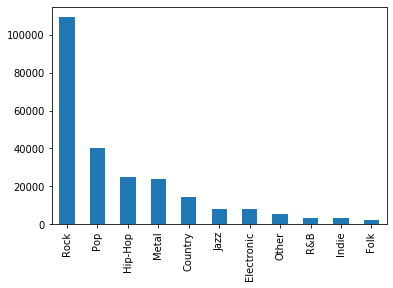

In [133]:
data['genre'].value_counts().plot.bar()

In [8]:
# Import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
genres_encoded = le.fit_transform(data["genre"].tolist())
genres_encoded

array([9, 9, 9, ..., 0, 0, 0])

In [21]:
classes = list(le.classes_)
codes = le.transform(list(le.classes_))
for clss, code in zip(classes, codes):
    print(clss, code)

Country 0
Electronic 1
Folk 2
Hip-Hop 3
Indie 4
Jazz 5
Metal 6
Not Available 7
Other 8
Pop 9
R&B 10
Rock 11


### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [43]:
from sklearn.model_selection import train_test_split

# Split songs dataset to train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(data["lyrics"].values, genres_encoded, test_size=0.2, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [137]:
X_train.shape

(155251,)

In [24]:
def clean_X(X):
    clean_X = []

    # Loop over each document; create an index i that goes from 0 to the length
    # of the train list 
    for i, val in enumerate(X):
        # Call our function for each one, and add the result to the list of clean reviews
        if ((i + 1) % 50000 == 0):
            print("Lyrics %d of %d\n" % (i + 1, X.size))
        clean_X.append(" ".join(document_to_words(val)))
  
    return clean_X

In [139]:
clean_X_train = clean_X(X_train)

Lyrics 50000 of 155251

Lyrics 100000 of 155251

Lyrics 150000 of 155251



In [140]:
clean_X_train[:3]

['if i didn t already love you i d fall in love tonight',
 'i m a game that you used to play and i m a plan that you didn t lay so well and i m a fire that burns in your mind so close your eyes i m a memory i m a love that you bought for a song and i m a voice on a green telephone and i m a day that lasted so long so close your eyes i m a memory i m a dream that comes with the night and i m a face that fades with the light and i m a tear that falls out of sight so close your eyes i m a memory i m a love that you bought for a song and i m a voice on a green telephone and i m a day that lasted so long so close your eyes i m a memory',
 'you say your hurting is over it feels like you re back from the dead but still i can t believe it s over and i can t get your sight your scent from my head it seems like these moments are lasting forever the times when we felt alive you carried my heart in the midst of this battle in your hands this time i won t try to reach you you re already too far gon

In [142]:
def vectorize_features(X, vectorizer):
      # fit_transform() does two functions: First, it fits the model
      # and learns the vocabulary; second, it transforms our training data
      # into feature vectors. The input to fit_transform should be a list of 
      # strings.
    features = vectorizer.fit_transform(X)

      # Numpy arrays are easy to work with, so convert the result to an 
      # array
    features = features.toarray()
    return features

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = None,
                             max_features = 15000) 

X_train_bows = vectorize_features(X_train, vectorizer)
X_test_bows = vectorize_features(X_test, vectorizer)

In [144]:
# See how the Vectorizer works
bows = vectorizer.fit_transform(['i eat the banana in the summer from banana tree', 'in the spring i ate bananas'])
print(bows.toarray())
print(vectorizer.get_feature_names())

[[0 2 0 1 1 1 0 1 2 1]
 [1 0 1 0 0 1 1 0 1 0]]
['ate', 'banana', 'bananas', 'eat', 'from', 'in', 'spring', 'summer', 'the', 'tree']


In [145]:
print(X_train_bows[:2])
print(y_train[:2])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[8 0]


In [146]:
from sklearn.naive_bayes import MultinomialNB

nbc = MultinomialNB()
nbc.fit(X_train_bows, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [147]:
y_pred = nbc.predict(X_test_bows)

Show the confusion matrix.

In [148]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[    0     3  2342    16    10     8     2   453     3     1    16]
 [    3     6  1149    39    17    18    13   223    13     1    92]
 [    0     2   278    14     1     0     4    68     4     1    33]
 [    0     7  4551    45     7     9    13   318     7     0    18]
 [    0     2   491     5     5     3     2    99     1     0     8]
 [    0     1  1207    34     8     7    10   313     2     0    32]
 [    0    18  3797    71    30    14    35   662    18     2   174]
 [    0     0   829    38     8     2     7   213     7     1     2]
 [    1    13  6297   181    42    31    29  1411    31     2    51]
 [    0     0   546    12     6     2     1   111     1     0     4]
 [    0    30 17565   343   119    76    87  3038    51     2   467]]


Show the classification report - precision, recall, f1 for each class.

In [149]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Country       0.00      0.00      0.00      2854
  Electronic       0.07      0.00      0.01      1574
        Folk       0.01      0.69      0.01       405
     Hip-Hop       0.06      0.01      0.02      4975
       Indie       0.02      0.01      0.01       616
        Jazz       0.04      0.00      0.01      1614
       Metal       0.17      0.01      0.01      4821
       Other       0.03      0.19      0.05      1107
         Pop       0.22      0.00      0.01      8089
         R&B       0.00      0.00      0.00       683
        Rock       0.52      0.02      0.04     21778

    accuracy                           0.02     48516
   macro avg       0.10      0.09      0.02     48516
weighted avg       0.30      0.02      0.02     48516



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [45]:
import numpy as np

def avg_word_vector(X):
    avg_vectors = [];
    # todo: can be better implemented with numpy
    for i, val in enumerate(X):
        total_vector = np.zeros(w2v_model.vector_size)
        words = val.split(" ")
        for word in words:
            total_vector += w2v_model[word] if word in w2v_model.wv.vocab else np.zeros(w2v_model.vector_size) 
        avg_vector = total_vector / len(words)
        avg_vectors.append(avg_vector)
    return avg_vectors

In [46]:
X_train_avg_vc = avg_word_vector(X_train)
X_test_avg_vc = avg_word_vector(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [17]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train_avg_vc)  
X_train_avg_vc_scaled = scaler.transform(X_train_avg_vc)  
# apply same transformation to test data
X_test_avg_vc_scaled = scaler.transform(X_test_avg_vc) 

In [18]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(50,))

#Train the model using the training sets
clf.fit(X_train_avg_vc_scaled, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_avg_vc_scaled)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[  854     2     1    21     0    28    11    15     2   220     0  1730]
 [   11    59     0    70     2     5    59    18     5   260     0  1074]
 [   20     4    14     1     0     1    15    12     0    31     0   323]
 [   10    17     0  3334     0     4    48    57    15   412     0   921]
 [    9     5     0     9     1     3    13     6     0    60     0   538]
 [  101     1     0    26     0   174    19    33    15   282     1   945]
 [   10     6     0    88     0     2  2044    35     0   111     1  2495]
 [  138    17     5   248     0    35   173   382    23   967     0  2890]
 [   27     6     0    80     0    59    28    67    22   174     0   565]
 [  167    34     0   304     0    66   115   172    13  2516     0  4713]
 [   21     1     0    18     0     6     8     5     1   145     0   464]
 [  543    49    11   347     2    89   727   230    19  1863     3 18024]]


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

               precision    recall  f1-score   support

      Country       0.45      0.30      0.36      2884
   Electronic       0.29      0.04      0.07      1563
         Folk       0.45      0.03      0.06       421
      Hip-Hop       0.73      0.69      0.71      4818
        Indie       0.20      0.00      0.00       644
         Jazz       0.37      0.11      0.17      1597
        Metal       0.63      0.43      0.51      4792
Not Available       0.37      0.08      0.13      4878
        Other       0.19      0.02      0.04      1028
          Pop       0.36      0.31      0.33      8100
          R&B       0.00      0.00      0.00       669
         Rock       0.52      0.82      0.64     21907

     accuracy                           0.51     53301
    macro avg       0.38      0.24      0.25     53301
 weighted avg       0.48      0.51      0.46     53301



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [27]:
X = clean_X(data["lyrics"].values)

Lyrics 50000 of 266505

Lyrics 100000 of 266505

Lyrics 150000 of 266505

Lyrics 200000 of 266505

Lyrics 250000 of 266505



In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5)

X_tfidf = vectorizer.fit_transform(X)

In [30]:
from sklearn.neural_network import MLPClassifier
 
clf = MLPClassifier(hidden_layer_sizes=(5,))

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [33]:
print(confusion_matrix(y_test, y_pred))

[[ 1078    27    30    35    26   119    44   141    48   292    28  1016]
 [   29   212    10    82    13    23   125    93    38   265    11   662]
 [   34     8    41     7     5    22    41    37    14    51     3   158]
 [   27    85     5  3145    10    20   116   282    81   411    28   608]
 [   30    20    10    29    24    19    40    26    13   103     3   327]
 [  174    19    11    35     8   401    43   127    63   228    18   470]
 [   54   106    37   170    38    34  2130   233    35   325     5  1625]
 [  264    93    28   317    28   144   266  1031   105   831    42  1729]
 [   49    45     9    89     6   128    59   107    96   152     8   280]
 [  359   192    37   385    45   256   302   670   109  3015    60  2670]
 [   53    10     1    37     5    24    24    63     7   115    59   271]
 [ 1095   444   145   654   225   449  1533  1362   287  2693   165 12855]]


In [32]:
print(classification_report(y_test, y_pred, target_names=classes))

               precision    recall  f1-score   support

      Country       0.33      0.37      0.35      2884
   Electronic       0.17      0.14      0.15      1563
         Folk       0.11      0.10      0.10       421
      Hip-Hop       0.63      0.65      0.64      4818
        Indie       0.06      0.04      0.04       644
         Jazz       0.24      0.25      0.25      1597
        Metal       0.45      0.44      0.45      4792
Not Available       0.25      0.21      0.23      4878
        Other       0.11      0.09      0.10      1028
          Pop       0.36      0.37      0.36      8100
          R&B       0.14      0.09      0.11       669
         Rock       0.57      0.59      0.58     21907

     accuracy                           0.45     53301
    macro avg       0.28      0.28      0.28     53301
 weighted avg       0.44      0.45      0.45     53301



### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.